# **What is METACALIBRATION?**

In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import galsim
rng = random.RandomState(314)

## How do digital images of galaxies are formed?

In [7]:
#set galaxy properties:
half_light_radius = .8
g = [0.1, 0.3]
flux=1000

#set image properties:
stamp_size = 51
pixel_scale = 0.2

noise_level = 1
noise_psf = 1e-5 #psf flux is normalized to 1

#draw galaxy surface brightness
galaxy=galsim.Exponential(flux=flux,half_light_radius=half_light_radius).shear(g1=g[0],g2=g[1])
galaxy_image = galaxy.drawImage(nx=510,ny=510,scale=pixel_scale/10).array

#draw psf distribution
psf = galsim.Moffat(beta=4.8,fwhm=0.7).shear(g1=0.01,g2=0.02)
psf_image = psf.drawImage(nx=stamp_size*10,ny=stamp_size*10,scale=pixel_scale/10).array

#convolve
obj = galsim.Convolve([galaxy,psf])
object_image = obj.drawImage(nx=stamp_size*10,ny=stamp_size*10,scale=pixel_scale/10).array

#pixelize
pixel_image = obj.drawImage(nx=stamp_size,ny=stamp_size,scale=pixel_scale).array
#add noise
final_image = pixel_image + noise_level*rng.normal(size=[stamp_size,stamp_size])


#psf model from stars
psf_model = psf.drawImage(nx=stamp_size,ny=stamp_size,scale=pixel_scale).array + noise_psf*rng.normal(size=[stamp_size,stamp_size])

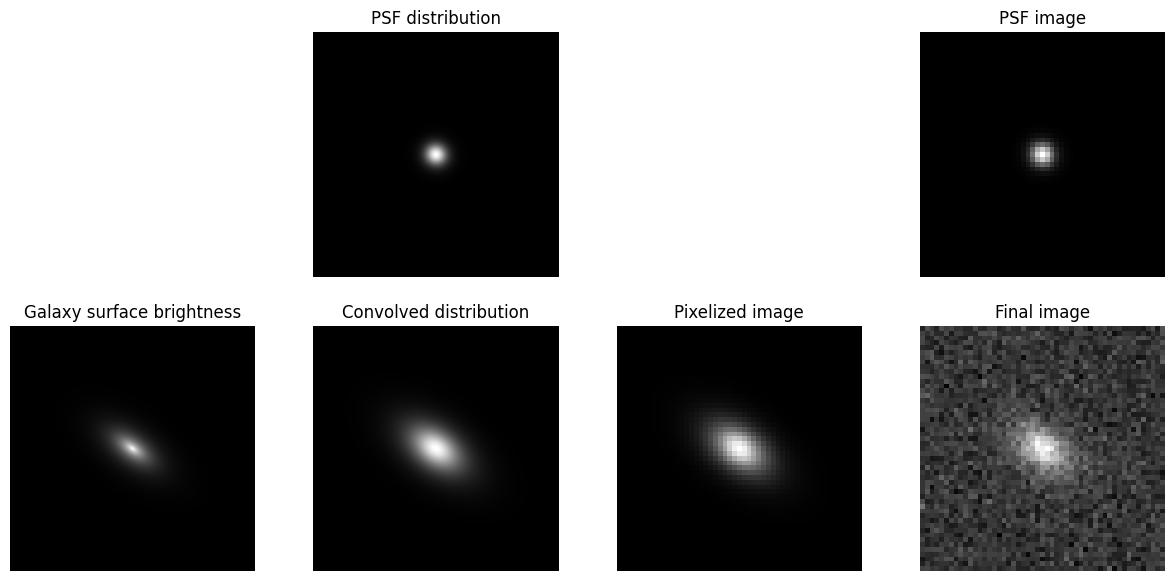

In [8]:
figure(figsize=(15,7))
subplot(245)
imshow(galaxy_image,cmap='gray');axis('off');title('Galaxy surface brightness')
subplot(242)
imshow(psf_image,cmap='gray');axis('off');title('PSF distribution')
subplot(246)
imshow(object_image,cmap='gray');axis('off');title('Convolved distribution')
subplot(247)
imshow(pixel_image,cmap='gray');axis('off');title('Pixelized image')
subplot(248)
imshow(final_image,cmap='gray');axis('off');title('Final image')
subplot(244)
imshow(psf_model,cmap='gray');axis('off');title('PSF image')
savefig('image_formation_paradigm.pdf',bbox_inches='tight')

# How do we measure ellipticities?

## 1) (Weighted) moments over the image

In [9]:
#adapted from EiffL @ github :) 
XX = np.zeros([stamp_size,stamp_size])
XY = np.zeros([stamp_size,stamp_size])
YY = np.zeros([stamp_size,stamp_size])
w  = np.zeros([stamp_size,stamp_size])
sigma=0.7/.2 #fwhm/pixel_scale

for i in range(0,stamp_size):
    x=0.5+i-(stamp_size)/2.0
    for j in range(0,stamp_size):
        y=0.5+j-(stamp_size)/2.0
        XX[i,j]=x*x
        XY[i,j]=x*y
        YY[i,j]=y*y
        w[i,j]=np.exp(-((x) ** 2 + (y) ** 2) /
                               (2 * sigma ** 2))

def get_ellipticity(img):
    norm = sum(w*img)
    Q11 = sum(w*img*YY)/norm
    Q12 = sum(w*img*XY)/norm
    Q21 = Q12
    Q22 = sum(w*img*XX)/norm
    
    q1 = Q11 - Q22
    q2 = 2*Q12
    
    T= Q11 + Q22  + 2*np.sqrt(Q11*Q22 - Q12**2)
    return array([q1/T, q2/T])

In [10]:
get_ellipticity(final_image)

array([0.03383021, 0.09506244])

## 2) Model fitting

In [11]:
def model(hlr,g1,g2,psf_fwhm,psf_g1,psf_g2):
  
  gal = galsim.Exponential(flux=flux,
    half_light_radius = hlr
  ).shear(
    g1=g1,
    g2=g2
  )
  
  psf = galsim.Moffat(beta=4.8,
    fwhm = psf_fwhm
  ).shear(
    g1=psf_g1,
    g2=psf_g2
  )
  
  model = galsim.Convolve([gal,psf])
  
  model_array = model.drawImage(
    nx=stamp_size,
    ny=stamp_size,
    scale=pixel_scale
  ).array
  
  return model_array

Let keep it simple for now and fit only the galaxy shape:

In [12]:
def loss(g):
  quadratic = sum((model(hlr=half_light_radius,g1=g[0],g2=g[1],psf_fwhm=0.7,psf_g1=0.01,psf_g2=0.02)-final_image)**2)
  return quadratic
  

In [13]:
from scipy.optimize import minimize

In [14]:
result=minimize(loss,array([0,0]),method='Nelder-Mead')
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2664.4576784873652
             x: [ 1.020e-01  2.899e-01]
           nit: 46
          nfev: 89
 final_simplex: (array([[ 1.020e-01,  2.899e-01],
                       [ 1.019e-01,  2.898e-01],
                       [ 1.020e-01,  2.899e-01]]), array([ 2.664e+03,  2.664e+03,  2.664e+03]))

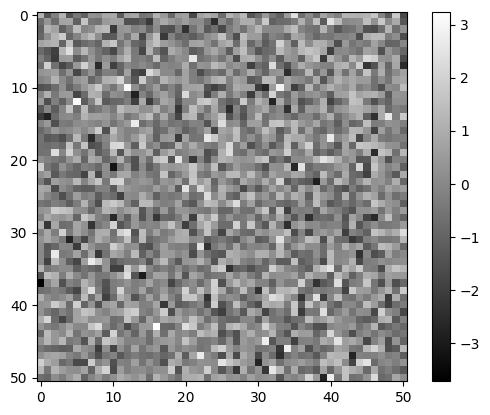

In [15]:
imshow(model(hlr=0.8,g1=result.x[0],g2=result.x[1],psf_fwhm=0.7,psf_g1=0.01,psf_g2=0.02)-final_image,cmap='gray');colorbar()

## METACALIBRATION

To come... :) 

We want to measure how much a galaxy changes due to shear. But shear happens on the galaxy surface brightness distribution, that is, before the convolution with the PSF.
Because of that, we need to deconvolve the galaxy by the PSF. We will believe our model is a good model of the PSF to do so.

In [16]:
#InterpolatedImage is a galsim object (GSObject) that can be manipulated by GalSim.
#GalSim will take care of the details for using FFT, that we will need for deconvolution. (Deconvolution is division in k-space)
psf_model_galsim = galsim.InterpolatedImage(galsim.Image(psf_model,scale=pixel_scale)) 

inverse_psf = galsim.Deconvolve(psf_model_galsim)

In [19]:
final_image_galsim = galsim.InterpolatedImage(galsim.Image(final_image,scale=pixel_scale))

In [20]:
deconvolved_galaxy = galsim.Convolve([final_image_galsim,inverse_psf]) #basically k-image/k-psf

Let's apply some shear and reconvolve this galaxy:

In [21]:
#shear in fourier space
deconvolved_galaxy = deconvolved_galaxy.shear(g1=0.01)
#create a reconvolution psf, we can choose, so we go circular!
reconvolution_psf = galsim.Moffat(beta=4.8,fwhm=0.7)
#reconvolve
reconvolved_galaxy = galsim.Convolve([deconvolved_galaxy,reconvolution_psf])

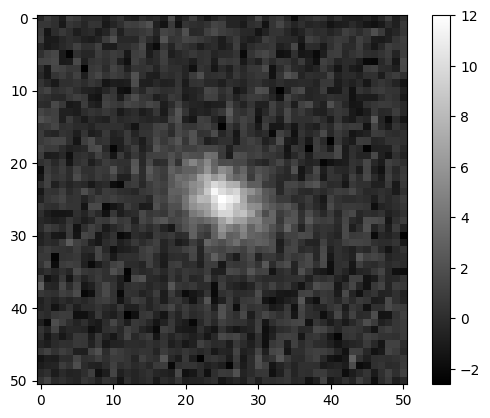

In [22]:
reconvolved_galaxy_image = reconvolved_galaxy.drawImage(nx=stamp_size,ny=stamp_size,scale=pixel_scale).array
imshow(reconvolved_galaxy_image,cmap='gray');colorbar()

However, dividing by a noisy psf model can make some high frequency modes (ie. far from center in kspace image) to go high. One way to kill this is to convolve with a larger psf (that will look smaller in k-space, ie., high frequencies get closer to zero... then killing these high frequence artifacts).

In [23]:
dilated_reconvolution_psf = galsim.Moffat(beta=4.8,fwhm=0.7*1.1) #10pct larger (in practice, it's less)

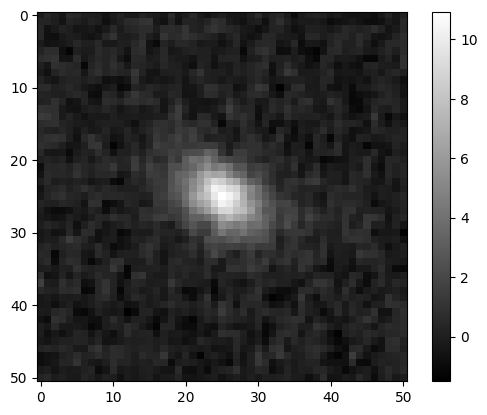

In [24]:
#reconvolve with dilated psf
reconvolved_galaxy = galsim.Convolve([deconvolved_galaxy,dilated_reconvolution_psf])
reconvolved_galaxy_image = reconvolved_galaxy.drawImage(nx=stamp_size,ny=stamp_size,scale=pixel_scale).array
imshow(reconvolved_galaxy_image,cmap='gray');colorbar()

Also, by shearing the noisy deconvoved image, we added some correlated noise. This will introduce biases in our ellipticity measurements. To account for that, we can create a noise image, and make it go through the same process as the galaxy goes, but with a 90 degree rotation, that will become a "counter-sheared" noise stamp. We will add this to the image above. This, of course, makes a noisier image then the original. We are, then, trading precision for accuracy.

In [25]:
#create a noise image with the same level of our image
noise_image = noise_level*random.normal(size=[stamp_size,stamp_size])

noise_galsim = galsim.InterpolatedImage(galsim.Image(noise_image,scale=pixel_scale))
#deconvolve noise! Yes, we need to make the noise go through the same process
deconvolved_noise = galsim.Convolve([noise_galsim,inverse_psf])
#apply shear
sheared_noise = deconvolved_noise.shear(g1=0.01)

#rotate noise
galsimrot90 = galsim.Angle(90,galsim.AngleUnit(pi/180.))
rotated_noise= sheared_noise.rotate(galsimrot90)

#reconvolve noise with psf
counter_sheared_noise_final = galsim.Convolve([rotated_noise,reconvolution_psf])

#convolution are linear operations, so conv(gal+noise,psf) = conv(gal,rpsf) + conv(noise,rpsf)
final_mcal_obj= reconvolved_galaxy + counter_sheared_noise_final

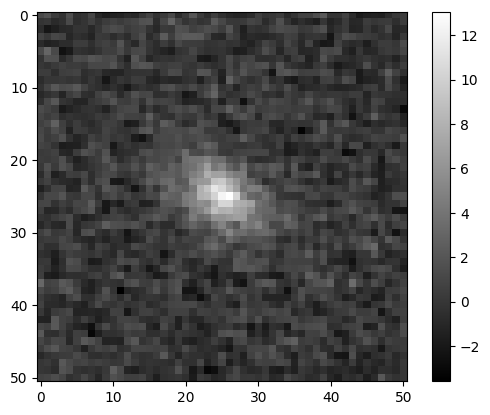

In [26]:
final_mcal_img = final_mcal_obj.drawImage(nx=stamp_size,ny=stamp_size,scale=pixel_scale).array
imshow(final_mcal_img,cmap='gray');colorbar()

In [27]:
def get_metacal_images(img,psf,g):
  g=array(g)
  
  #make galsim objects
  psf_model_galsim = galsim.InterpolatedImage(galsim.Image(psf,scale=pixel_scale))
  final_image_galsim = galsim.InterpolatedImage(galsim.Image(img,scale=pixel_scale))
  #invert psf
  inverse_psf = galsim.Deconvolve(psf_model_galsim)
  #deconvolve psf from galaxy
  deconvolved_galaxy = galsim.Convolve([final_image_galsim,inverse_psf]) #basically k-image/k-psf
  #shear idrawImageier space
  deconvolved_galaxy = deconvolved_galaxy.shear(g1=g[0],g2=g[1])
  #create a dilated reconvolution psf. We can choose, so we go circular!
  reconvolution_psf = galsim.Moffat(beta=4.8,fwhm=0.7*(1+2*linalg.norm(g)) )
  #reconvolve
  reconvolved_galaxy = galsim.Convolve([deconvolved_galaxy,reconvolution_psf])

  return reconvolved_galaxy.drawImage(nx=stamp_size,ny=stamp_size,scale=pixel_scale).array

In [28]:
step = 0.01

metacal_image_types = ['noshear','1p','1m','2p','2m']
metacal_shears = {
  'noshear':[0,0],
  '1p':[step,0],
  '1m':[-step,0],
  '2p':[0,step],
  '2m':[0,-step] 
}

metacal_images = {}

fixnoise=True
for key in metacal_image_types:
  image = get_metacal_images(final_image,psf_model,g=metacal_shears[key])
  
  if fixnoise:
    #create a noise image with the same level of our image and rotate it
    noise_image = noise_level*rng.normal(size=[stamp_size,stamp_size])
    fixnoise_image = get_metacal_images(noise_image,psf_model,g=metacal_shears[key])
    fixnoise_image=np.rot90(fixnoise_image)
    image +=fixnoise_image
  
  metacal_images.update({key : image}) 


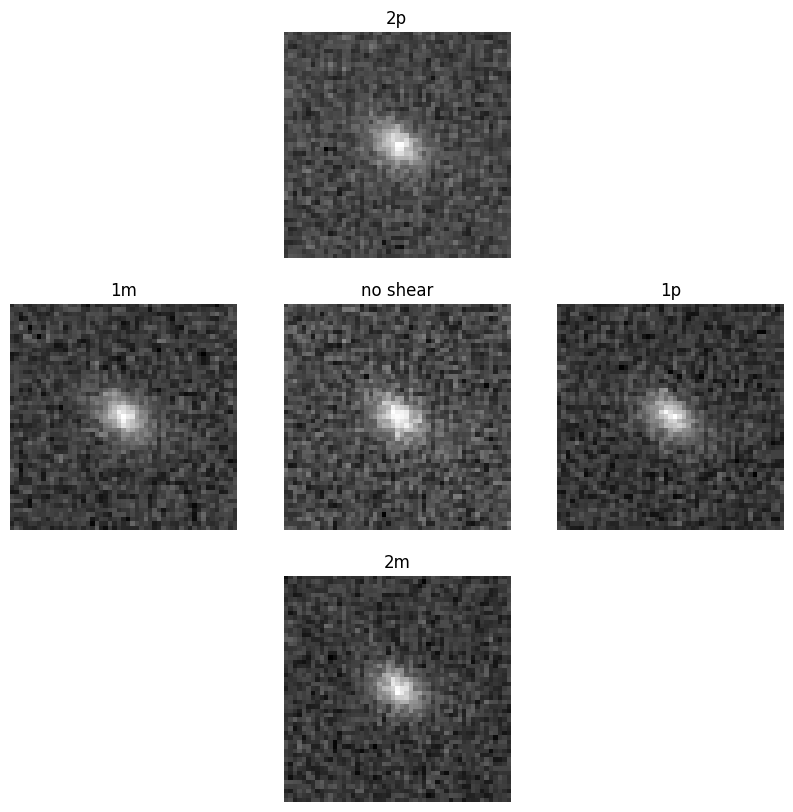

In [29]:
figure(figsize=(10,10))
subplot(332)
imshow(metacal_images['2p'],cmap='gray');axis('off');title('2p')
subplot(334)
imshow(metacal_images['1m'],cmap='gray');axis('off');title('1m')
subplot(335)
imshow(metacal_images['noshear'],cmap='gray');axis('off');title('no shear')
subplot(336)
imshow(metacal_images['1p'],cmap='gray');axis('off');title('1p')
subplot(338)
imshow(metacal_images['2m'],cmap='gray');axis('off');title('2m')
savefig('gallery_of_metacal_images.png',bbox_inches='tight')

In [30]:
resdict = {}

for key in metacal_images.keys():
  moments_ellips= get_ellipticity(metacal_images[key])
  
  resdict.update({key:{'g':moments_ellips}})
  

In [31]:
def get_metacal_response(resdict,shear_type = 'g'):
  '''gets the shear response for ngmix-like results'''

  #noshear
  g0s = np.array(resdict['noshear'][shear_type])
  
  #shear
  g1p = np.array(resdict['1p'][shear_type])
  g1m = np.array(resdict['1m'][shear_type])
  g2p = np.array(resdict['2p'][shear_type])
  g2m = np.array(resdict['2m'][shear_type])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])

  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,  
  } 
      
  return ellip_dict, R

In [32]:
e, R =get_metacal_response(resdict)

In [33]:
linalg.inv(R) @ e['noshear']

array([ 0.14357992, -0.08036649])

In [34]:
get_ellipticity(final_image)

array([0.03383021, 0.09506244])

## Ellipticities vs Shear

TODO: create many galaxies, average them.

In [35]:
#make 1000 galaxies
galaxies = []
for i in range(100):
  image = model(hlr=0.8,g1=g[0],g2=g[1],psf_fwhm=0.7,psf_g1=0.01,psf_g2=0.02) + noise_level*rng.normal(size=[stamp_size,stamp_size])
  galaxies +=[image]

In [36]:
def loss_img(img):
  quadratic = lambda g: sum((model(hlr=0.8,g1=g[0],g2=g[1],psf_fwhm=0.7,psf_g1=0.01,psf_g2=0.02)-img)**2)
  return quadratic
  

In [37]:
e_moments_list = []
e_fitting_list = []
for galaxy in galaxies:
  #moments
  e_moments = get_ellipticity(galaxy)
  e_moments_list += [e_moments]
  
  #fitting
  lost = loss_img(galaxy)
  result=minimize(lost,array([0,0]),method='Nelder-Mead')
  
  e_fitting_list += [array(result.x)] 
  
  
  

In [40]:
e_moms = array(e_moments_list)
e_fits = array(e_fitting_list)

(array([ 3.,  2.,  7., 13., 17., 20., 15.,  6., 13.,  4.]),
 array([0.24558978, 0.25506096, 0.26453214, 0.27400332, 0.2834745 ,
        0.29294568, 0.30241686, 0.31188804, 0.32135922, 0.3308304 ,
        0.34030158]),
 <BarContainer object of 10 artists>)

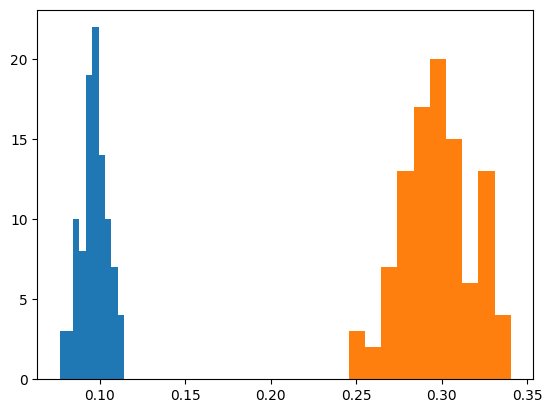

In [41]:
hist(e_moms[:,1])
hist(e_fits[:,1])

In [42]:
def do_metacal(img,psf,method):
  step = 0.01

  metacal_image_types = ['noshear','1p','1m','2p','2m']
  metacal_shears = {
    'noshear':[0,0],
    '1p':[step,0],
    '1m':[-step,0],
    '2p':[0,step],
    '2m':[0,-step] 
  }

  obsdict = {}
  resdict = {}
  fixnoise=True
  for key in metacal_image_types:
    image = get_metacal_images(img,psf,g=metacal_shears[key])

    if fixnoise:
      #create a noise image with the same level of our image and rotate it
      noise_image = noise_level*rng.normal(size=[stamp_size,stamp_size])
      fixnoise_image = get_metacal_images(noise_image,psf,g=metacal_shears[key])
      fixnoise_image=np.rot90(fixnoise_image)
      image +=fixnoise_image
  
    obsdict.update({key : image})
    
    method_ellips= method(image)
    
    resdict.update({key:{'g':method_ellips}})
  
  
  return resdict

In [43]:
def fit_ellipticity(img):
  lost = loss_img(img)
  result=minimize(lost,array([0,0]),method='Nelder-Mead')
  return result.x  

In [44]:
e_moments_metacal_list = []
e_fitting_metacal_list = []
for galaxy in galaxies:
  resdict_m = do_metacal(galaxy,psf_model,get_ellipticity)
  e_moments_metacal_list += [resdict_m]
  resdict_f = do_metacal(galaxy,psf_model,fit_ellipticity)
  e_fitting_metacal_list += [resdict_f]

In [45]:
moms_results_e = []
moms_results_R = []
fits_results_e = []
fits_results_R = []

for resdict in e_moments_metacal_list:
  e_mom, R_mom = get_metacal_response(resdict)
  moms_results_e += [e_mom]
  moms_results_R += [R_mom]
  
for resdict in e_moments_metacal_list:
  e_fit, R_fit = get_metacal_response(resdict)
  fits_results_e += [e_fit]
  fits_results_R += [R_fit]

In [46]:
e_moms = array([results['noshear'] for results in moms_results_e])
R_moms = array(moms_results_R)

In [47]:
R_moms.shape

(100, 2, 2)

(array([ 2.,  4., 12., 16., 21., 19., 15.,  7.,  2.,  2.]),
 array([0.06285184, 0.06913882, 0.07542579, 0.08171276, 0.08799973,
        0.0942867 , 0.10057368, 0.10686065, 0.11314762, 0.11943459,
        0.12572157]),
 <BarContainer object of 10 artists>)

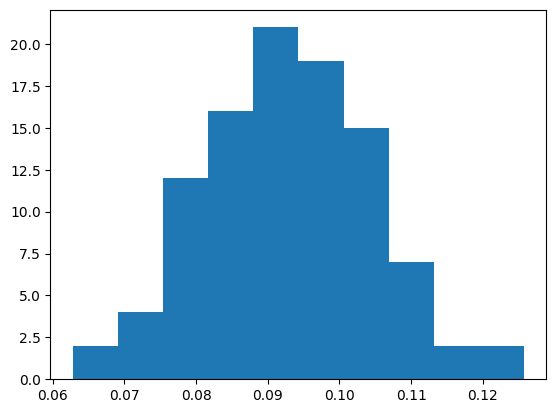

In [48]:
hist(e_moms[:,1])